In [1]:
# Python import 
import glob
import os
import numpy as np
import math 
import pandas as pd 
import time
import collections
import shutil
# Sitk
import SimpleITK as sitk
# Pytorch
import torch
import torch.cuda
from torch.utils.data import Dataset
# Skimage, Image processing
import skimage
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from skimage import morphology
from skimage import measure
from skimage.transform import resize
# Pillow
from PIL import Image, ImageDraw
# Scipy
from scipy import ndimage as ndi
# Matplotlib
import matplotlib.pyplot as plt # pip install matplotlib==2.2.3
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

HIGH_LIMIT = 1000
LOW_LIMIT = -1000
THRESHOLD = -400 # Unit HU #[-800 # -700 # -600 # -500, -400. -300]  this is good 

df_node = pd.read_csv("data/annotations.csv")


In [2]:
def circle_gt(series_uid, origin, spacing):
    # for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["seriesuid"]==series_uid]  #get all nodules associate with file
    ans = []
    if mini_df.shape[0] > 0:  # some files may not have a nodule--skipping those
        for node_idx, cur_row in mini_df.iterrows():
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]

            # Get v_center
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint(abs(center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            # print(f"center = {center}") # This is weird cooridiate 
            # print(f"v_center = {v_center}") # This is pixel cooridinate
            vx, vy, vz = v_center
            x1 = int(vx-diam)
            y1 = int(vy-diam)
            x2 = int(vx+diam)
            y2 = int(vy+diam)
            ans.append( (int(vz), x1, y1, x2, y2) )
    return ans

def get_segmented_lungs(im):
    # Reference : https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < THRESHOLD
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                    label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    # 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2) # This is kind of weird
    binary = binary_erosion(binary, selem)
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    # im[get_high_vals] = 0
    im[get_high_vals] = LOW_LIMIT
    return im

# series_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637"
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def refine_rp(raw_can):
    refine_can = []
    for seg_idx in range(len(raw_can)):
        r_list = []
        for r in raw_can[seg_idx]:
            x_l, y_l = r.centroid
            a_l = r.area
            # Find the largest area in afterwards images
            done = False
            for seg_idx_tmp in range(seg_idx+1, len(raw_can), 1):
                is_consecutive = False
                if seg_idx_tmp >= len(raw_can):
                    break
                
                for r_tmp in raw_can[seg_idx_tmp]: # Search all candidate 
                    x_tmp, y_tmp = r_tmp.centroid
                    if abs(x_tmp - x_l) + abs(y_tmp - y_l) < 6: # Consider as the same object
                        is_consecutive = True
                        # Found the object in afterward image
                        if r_tmp.area >= a_l:
                            # The search is done and we don't need to keep it
                            done = True
                            break
                        else:
                            # Replace x_c, y_c and keep searching next frame
                            x_l = x_tmp
                            y_l = y_tmp
                            a_l = r_tmp.area
                            break
                if done:
                    break
                if not is_consecutive:
                    # Look back one frame to check there's no object before
                    is_replicate = False
                    if seg_idx != 0:
                        x_l, y_l = r.centroid
                        for r_tmp in refine_can[seg_idx-1]:
                            x_tmp, y_tmp = r_tmp.centroid
                            if abs(x_tmp - x_l) + abs(y_tmp - y_l) < 6: # Consider as the same object
                                is_replicate = True
                                break
                    if not is_replicate:
                        r_list.append(r) # Done search, 
                    
                    # r_list.append(r) # Done search, 
                    break
        refine_can.append(r_list)
    return refine_can

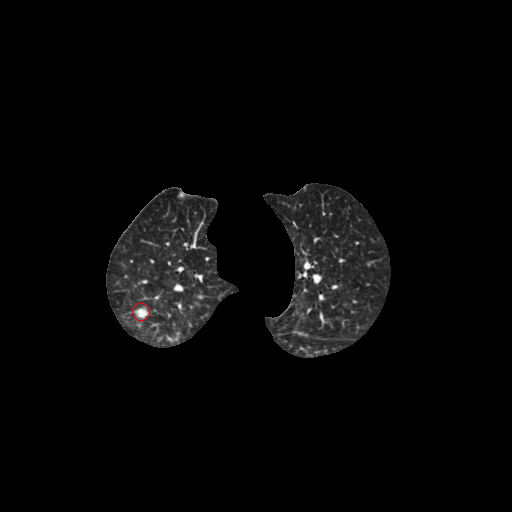

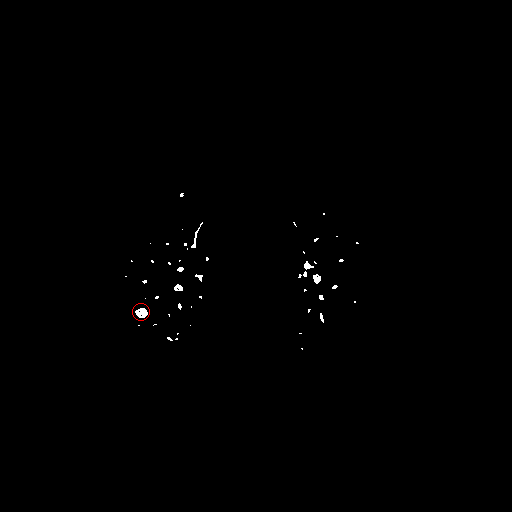

r_candidate_list number of region : 327
Candidates: 
(x, y, z, area) = (287.81081081081084, 178.01351351351352, 201, 74)
(x, y, z, area) = (289.7, 304.5, 201, 10)
(x, y, z, area) = (312.4594594594595, 141.03603603603602, 201, 111)


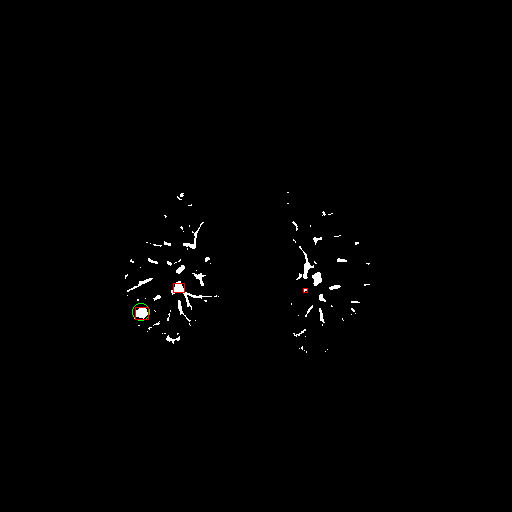

Processed 253/267


In [33]:
# There's a very big nodule in the lung, but been segmented out 
# 1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746
# bad noise and big tumor
# 1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391
# This mhd have very serious noise
# 1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053
# This is a very good example 
# 1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990
VIZ = True # whether to output viz result
DISPLAY = True # if wanna to display image to screen 
DELETE_GT_PROP = False # Switch to True if wanna output candidate.csv for training
APPEND_GT = False # Switch to True if wanna train 
OUTPUT_CSV = "preprocessing_train.csv"
INPUT_DIR = "data/train/"

if VIZ:
    shutil.rmtree("./viz/", ignore_errors=True)
    os.mkdir("./viz/")

# For output df
o_seriesuid = []
o_coordX = []
o_coordY = []
o_coordZ = []
o_class = []

mhd_list = glob.glob(INPUT_DIR + "*.mhd")
for mhd_idx, fn in enumerate(mhd_list):
    series_uid = os.path.split(fn)[1][:-4]

    if series_uid != "1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990":
        continue
    # Load image
    ct_mhd = sitk.ReadImage( fn )
    origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
    vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
    direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a.clip(LOW_LIMIT, HIGH_LIMIT, ct_a)

    # Get origin spacing 
    origin = np.array(ct_mhd.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(ct_mhd.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    # New numpy array for lung and nodule segmented
    lung_a   = np.zeros(ct_a.shape)
    nodule_a = np.zeros(ct_a.shape)
    # 
    N_depth = ct_a.shape[0]
    n_col = math.floor(math.sqrt(N_depth))
    n_row = math.ceil(N_depth/n_col)
    # Output serious of image, make it view as viedeo
    gt_bb = circle_gt(series_uid, origin, spacing)

    for idx in range(N_depth):
        # segment lung
        lung_a[idx] = get_segmented_lungs(ct_a[idx])

        # Segment nodule
        nodule_a[idx] = lung_a[idx]
        nodule_a[idx][nodule_a[idx] < THRESHOLD] = LOW_LIMIT
        nodule_a[idx] += -LOW_LIMIT
        nodule_a[idx] *= (255.0/HIGH_LIMIT)
        nodule_a[idx] = nodule_a[idx].astype('uint8')
        nodule_a[idx][nodule_a[idx] > 0] = 255

        # normalize segment lung
        lung_a[idx] += -LOW_LIMIT
        lung_a[idx] *= (255.0/HIGH_LIMIT)
    # Output video, nodule with red circle
    # 
    if VIZ:
        os.mkdir(f"./viz/{series_uid}")
        os.mkdir(f"./viz/{series_uid}/lung/")
        os.mkdir(f"./viz/{series_uid}/nodule/")
        for vz, x1, y1, x2, y2 in gt_bb:
            # Save viz image
            for idx in range(vz-5, vz+5, 1):
                #
                img_lung = Image.fromarray(lung_a[idx])
                img_lung = img_lung.convert("RGB")
                #
                img_nodule = Image.fromarray(nodule_a[idx])
                img_nodule = img_nodule.convert("RGB")
                #
                draw_lung = ImageDraw.Draw(img_lung)
                draw_lung.ellipse((x1, y1, x2, y2), outline = "red")
                draw_nodule = ImageDraw.Draw(img_nodule)
                draw_nodule.ellipse((x1, y1, x2, y2), outline = "red")
                # Display image ground true image to screen
                if DISPLAY and idx == vz:
                    display(img_lung)
                    display(img_nodule)
                # Save image to file
                img_lung.save(f'viz/{series_uid}/lung/{idx}.png')
                img_nodule.save(f'viz/{series_uid}/nodule/{idx}.png')

    #############################
    ###  Post-process nodules ###
    #############################
    r_candidate_list = []
    seg_a_viz = nodule_a.copy()
    for seg_idx in range(N_depth):
        try:
            seg_a = nodule_a[seg_idx] + nodule_a[seg_idx-1] + nodule_a[seg_idx+1]
        except IndexError as e :
            seg_a = nodule_a[seg_idx]
        seg_a[seg_a > 0] = 255

        # Get connected component
        label_scan, num  = label(seg_a, background=0, connectivity=1, return_num = True)
        # print(f"Number of connected region: {num}")
        # Get region proposal
        props = regionprops(label_scan)
        # For viz 
        seg_a_viz[seg_idx] = seg_a
        # Select candidate
        r_candidate = []
        for r in props:
            # Elimiate too small area and too large area
            if r.area >= 10 and r.area <= 800 and r.eccentricity < 0.9 and r.extent > 0.6:
                r_candidate.append(r)
        r_candidate_list.append(r_candidate)

    # Refine RPs 
    r_candidate_list = refine_rp(r_candidate_list)
    n_region = 0
    for x in r_candidate_list:
        n_region += len(x)
    print(f"r_candidate_list number of region : {n_region}")
    
    # Delete region proposal if there's a GT
    if DELETE_GT_PROP:# This will only be used, when outputing candidate.csv for training
        for vz, x1, y1, x2, y2 in gt_bb:
            x_gt = (x1+x2)/2
            y_gt = (y1+y2)/2
            for clean_idx in range(vz-3, vz+3, 1):
                for i, r in enumerate(r_candidate_list[clean_idx]):
                    x_c, y_c = r.centroid
                    if abs(x_gt - x_c) + abs(y_gt - y_c) < 12: # Consider as the same object
                        del r_candidate_list[clean_idx][i]
                        break
    
    # Visualization
    if VIZ:
        os.mkdir(f"./viz/{series_uid}/candidate/")
        for seg_idx in range(N_depth):
            # Visualization 
            # img = Image.fromarray(seg_a_viz[seg_idx])
            if seg_idx != 201:
                continue
            img = Image.fromarray(seg_a_viz[seg_idx] + seg_a_viz[seg_idx-1] + seg_a_viz[seg_idx+1])
            img = img.convert("RGB")

            # Draw Ground true 
            for vz, x1, y1, x2, y2 in gt_bb:
                if int(vz) == seg_idx:
                    draw = ImageDraw.Draw(img)
                    draw.ellipse((x1, y1, x2, y2), outline=(0, 255, 0))
            
            # Draw Region Proposal
            for r in r_candidate_list[seg_idx]:
                x_c, y_c = r.centroid
                y1, x1, y2, x2 = r.bbox
                draw = ImageDraw.Draw(img)
                draw.rectangle((x1, y1, x2, y2), outline='red', width =1 )

            # Viz
            for vz, x1, y1, x2, y2 in gt_bb:
                if abs(seg_idx - vz) < 5:
                    img.save(f'viz/{series_uid}/candidate/{seg_idx}.png')
                if DISPLAY and seg_idx == vz:
                    print("Candidates: ")
                    for r in r_candidate_list[seg_idx]:
                        print(f"(x, y, z, area) = {r.centroid[0], r.centroid[1], vz, r.area}")
                    display(img)

    # Output candidate, class = 0
    for seg_idx in range(N_depth):
        for r in r_candidate_list[seg_idx]:
            x_c, y_c = r.centroid
            # Output candidate
            xyz = irc2xyz( IrcTuple(seg_idx, x_c, y_c), origin_xyz, vxSize_xyz, direction_a)
            o_seriesuid.append(series_uid)
            o_coordX.append( round(xyz.x, 9) )
            o_coordY.append( round(xyz.y, 9) )
            o_coordZ.append( round(xyz.z, 9) )
            o_class.append(0)

    # Output gt to candidate, class = 1
    if APPEND_GT:
        mini_df = df_node[df_node["seriesuid"]==series_uid]
        for node_idx, cur_row in mini_df.iterrows():
            o_seriesuid.append(series_uid)
            o_coordX.append( cur_row["coordX"] )
            o_coordY.append( cur_row["coordY"] )
            o_coordZ.append( cur_row["coordZ"] )
            o_class.append(1)

    print(f"Processed {mhd_idx+1}/{len(mhd_list)}")

##############################
###  Output result to csv  ###
##############################
df_output = pd.DataFrame()
df_output['seriesuid'] = o_seriesuid
df_output['coordX'] = o_coordX
df_output['coordY'] = o_coordY
df_output['coordZ'] = o_coordZ
df_output['class'] = o_class
df_output.to_csv(OUTPUT_CSV, index = False)


In [ ]:
def plot_3d(image):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    # verts, faces = measure.marching_cubes(p, THRESHOLD)
    verts, faces = measure.marching_cubes_classic(p, THRESHOLD)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
# plot_3d(array_3d_nodule)

# This is for purely visulization 

Original Image


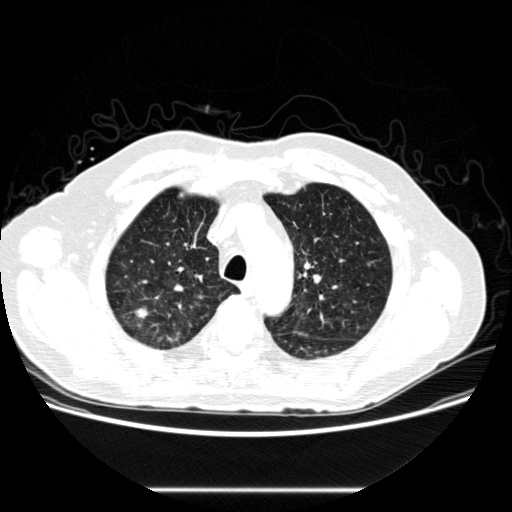

Thresholding
clear border
Get two largest connected component
Morphological image processing: Closing, Erosion
Final Output


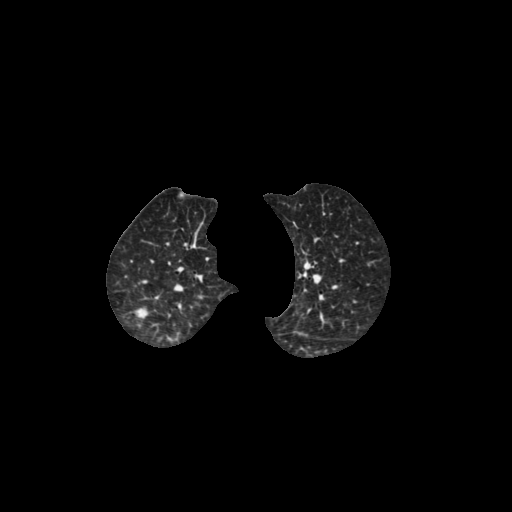

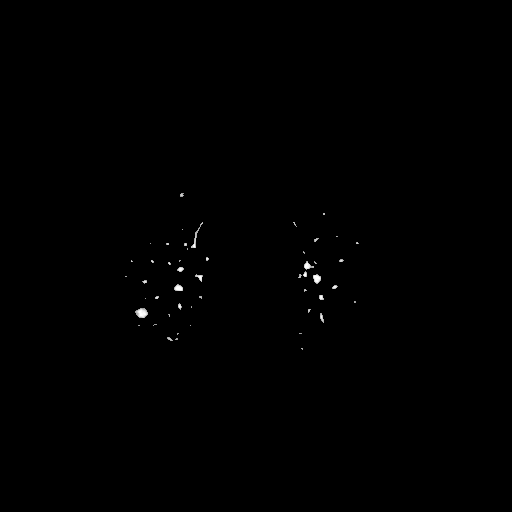

In [30]:
ct_mhd = sitk.ReadImage( "data/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.mhd" )
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)[201]
ct_a.clip(LOW_LIMIT, HIGH_LIMIT, ct_a)
THRESHOLD = -400
print("Original Image")
ori_a = (ct_a - LOW_LIMIT)*(255.0/ct_a.max())
img = Image.fromarray(ori_a)
img = img.convert("RGB")
display(img)
'''
Step 1: Convert into a binary image. 
'''
binary = ct_a < THRESHOLD

print("Thresholding")
img = Image.fromarray(binary)
img = img.convert("RGB")
# display(img)
'''
Step 2: Remove the blobs connected to the border of the image.
'''
cleared = clear_border(binary)

print("clear border")
img = Image.fromarray(cleared)
img = img.convert("RGB")
# display(img)

'''
Step 3: Label the image.
'''
label_image = label(cleared)
'''
Step 4: Keep the labels with 2 largest areas.
'''
areas = [r.area for r in regionprops(label_image)]
areas.sort()
if len(areas) > 2:
    for region in regionprops(label_image):
        if region.area < areas[-2]:
            for coordinates in region.coords:                
                label_image[coordinates[0], coordinates[1]] = 0
binary = label_image > 0


print("Get two largest connected component")
img = Image.fromarray(binary)
img = img.convert("RGB")
# display(img)


# 
'''
Step 5: Erosion operation with a disk of radius 2. This operation is 
seperate the lung nodules attached to the blood vessels.
'''

selem = disk(2) # This is kind of weird
binary = binary_erosion(binary, selem)
'''
Step 6: Closure operation with a disk of radius 10. This operation is 
to keep nodules attached to the lung wall.
'''
selem = disk(10)
binary = binary_closing(binary, selem)
'''
Step 7: Fill in the small holes inside the binary mask of lungs.
'''
edges = roberts(binary)
binary = ndi.binary_fill_holes(edges)

print("Morphological image processing: Closing, Erosion")
img = Image.fromarray(binary)
img = img.convert("RGB")
# display(img)

'''
Step 8: Superimpose the binary mask on the input image.
'''
get_high_vals = binary == 0
ct_a[get_high_vals] = LOW_LIMIT

print("Final Output")
final_a = (ct_a - LOW_LIMIT)
final_a *= (255.0/final_a.max())
img = Image.fromarray(final_a)
img = img.convert("RGB")
display(img)



ct_a[ct_a < THRESHOLD] = LOW_LIMIT
ct_a += -LOW_LIMIT
ct_a *= (255.0/HIGH_LIMIT)
img = Image.fromarray(ct_a)
img = img.convert("RGB")
display(img)


